In [35]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from opentn.states.qubits import up, down
from opentn.transformations import exp_operator_dt, create_2local_liouvillians
sigma_plus = np.outer(down, up)
sigma_minus = np.outer(up, down)

tau = 1
lambda_zero = 1
nu = 0.5

L1 = np.sqrt(lambda_zero * (nu + 1)) * sigma_minus
L2 = np.sqrt(lambda_zero * nu) * sigma_plus
lindbladians = [L1, L2]

N = 1
d = 2

# this would create odd = full, and even is empty
Lvec, Lvec_odd, Lvec_even = create_2local_liouvillians(Li=lindbladians, N=N, d=d, pbc=False)
exp_Lvec = exp_operator_dt(Lvec, tau, "jax")

In [66]:
from opentn.transformations import dissipative2liouvillian_full, op2fullspace

op = L2
print(np.allclose(op, op2fullspace(op=op, i=0, N=1, num_sites=1)))



Lvec_test = dissipative2liouvillian_full(L=L1, i=0, N=1, num_sites=1)
Lvec_test += dissipative2liouvillian_full(L=L2, i=0, N=1, num_sites=1)
np.allclose(Lvec_test, Lvec)

True


True

In [114]:
from opentn.structure_preserving import composition, unnormalized_scheme
start_timesteps_scheme = 10
num_timesteps_scheme = 100
superop_ord_1_ts = [composition(unnormalized_scheme(lindbladians=lindbladians, N=N, d=d, dt=tau/n, order=1, pbc=False), n=n) for n in range(start_timesteps_scheme, num_timesteps_scheme + 1)]
superop_ord_2_ts = [composition(unnormalized_scheme(lindbladians=lindbladians, N=N, d=d, dt=tau/n, order=2, pbc=False), n=n) for n in range(start_timesteps_scheme, num_timesteps_scheme + 1)]
superop_ord_3_ts = [composition(unnormalized_scheme(lindbladians=lindbladians, N=N, d=d, dt=tau/n, order=3, pbc=False, verbose=True), n=n) for n in range(start_timesteps_scheme, num_timesteps_scheme + 1)]

currently using dt=0.1, M=3
currently using dt=0.09090909090909091, M=3
currently using dt=0.08333333333333333, M=3
currently using dt=0.07692307692307693, M=3
currently using dt=0.07142857142857142, M=3
currently using dt=0.06666666666666667, M=3
currently using dt=0.0625, M=3
currently using dt=0.058823529411764705, M=3
currently using dt=0.05555555555555555, M=3
currently using dt=0.05263157894736842, M=3
currently using dt=0.05, M=3
currently using dt=0.047619047619047616, M=3
currently using dt=0.045454545454545456, M=3
currently using dt=0.043478260869565216, M=3
currently using dt=0.041666666666666664, M=3
currently using dt=0.04, M=3
currently using dt=0.038461538461538464, M=3
currently using dt=0.037037037037037035, M=3
currently using dt=0.03571428571428571, M=3
currently using dt=0.034482758620689655, M=3
currently using dt=0.03333333333333333, M=3
currently using dt=0.03225806451612903, M=3
currently using dt=0.03125, M=3
currently using dt=0.030303030303030304, M=3
curren

In [112]:
from opentn.optimization import get_general_trotter_local_ansatz, model_stiefel_local
from opentn.transformations import compose_superops_list, super2ortho

# superop_nonopt_ts = []
# for n in range(1, num_timesteps_scheme + 1):
#     xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=lindbladians, tau=tau, n=n)]
#     superop_nonopt_ts.append(model_stiefel_local(xs_trotter_ts, N, d))

# superop_nonopt_ts = [compose_superops_list(get_general_trotter_local_ansatz(lindbladians=lindbladians, tau=tau, n=n)) for n in range(1, num_timesteps_scheme + 1)]

# compose_superops_list(get_general_trotter_local_ansatz(lindbladians=lindbladians, tau=tau, n=1))

In [113]:
# compose_superops_list(get_general_trotter_local_ansatz(lindbladians=lindbladians, tau=tau, n=2))

In [115]:
from opentn.structure_preserving import random_psd_error
error_order_1_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error= superop_ord_1_ts, normalize=False, iterations=20)
error_order_2_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error= superop_ord_2_ts, normalize=False, iterations=20)
error_order_3_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error = superop_ord_3_ts, normalize=False, iterations=20)

In [93]:
# error_nonopt_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts, normalize=False)

In [116]:
errors_unnorm = [error_order_1_unnorm, error_order_2_unnorm, error_order_3_unnorm]

In [117]:
error_order_1_norm = random_psd_error(superop_exact=exp_Lvec, superops_error= superop_ord_1_ts, normalize=True, iterations=20)
error_order_2_norm = random_psd_error(superop_exact=exp_Lvec, superops_error= superop_ord_2_ts, normalize=True, iterations=20)
error_order_3_norm = random_psd_error(superop_exact=exp_Lvec, superops_error = superop_ord_3_ts, normalize=True, iterations=20)

In [118]:
errors_norm = [error_order_1_norm, error_order_2_norm, error_order_3_norm]

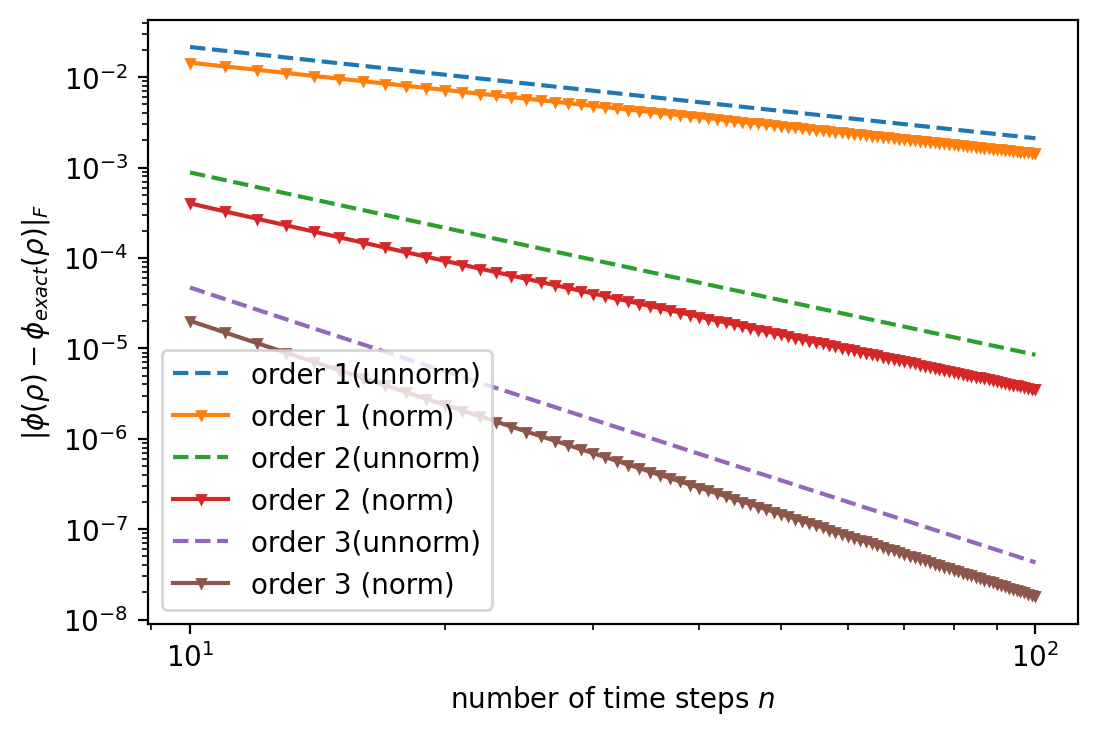

In [121]:
idx = 0
labels = ['order 1', 'order 2', 'order 3'][idx:]
fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi(\rho) - \phi_{exact}(\rho) \right|_F $')
plt.xlabel('number of time steps $n$')
for i, (unnorm, norm) in enumerate(zip(errors_unnorm[idx:], errors_norm[idx:])):
    plt.loglog(range(start_timesteps_scheme, num_timesteps_scheme+1), unnorm[:], '--', label=labels[i] + '(unnorm)')
    plt.loglog(range(start_timesteps_scheme, num_timesteps_scheme+1),norm[:], '-v', label=labels[i] + ' (norm)', markersize=3)
plt.legend()